In [1]:
!pip install pycocotools

Check files present in the private preprocessed dataset

In [2]:
import os

dataset_path = "/kaggle/input/hubmap-preprocessed-data/my-hubmap-hacking-the-human-vasculature-dataset-old-combined/coco_data"

# List all files in the dataset
files = os.listdir(dataset_path)
print("Files in dataset:", files)

Files in dataset: ['coco_data.json', 'coco_test_data.json', 'data', 'coco_train_data.json', 'test', 'train']


In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


Load all images

In [4]:
import os
import json
from pycocotools.coco import COCO

# point to COCO dataset and annotations file
coco_path = "/kaggle/input/hubmap-preprocessed-data/my-hubmap-hacking-the-human-vasculature-dataset-old-combined/coco_data"
annotations_file = os.path.join(coco_path, "coco_data.json")  # Change this if your JSON has a different name

# load COCO annotations
coco = COCO(annotations_file)

# get all image IDs
image_ids = coco.getImgIds()
print("Total Images:", len(image_ids))

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
Total Images: 422


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils
from pycocotools import mask as maskUtils

Load one sample image and its mask

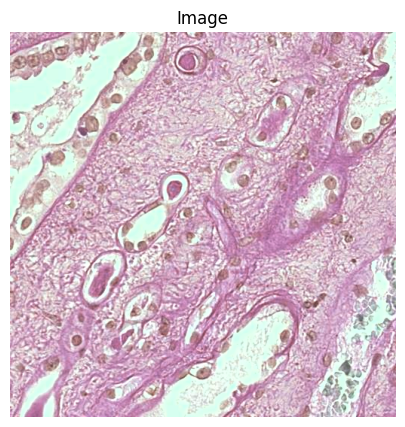

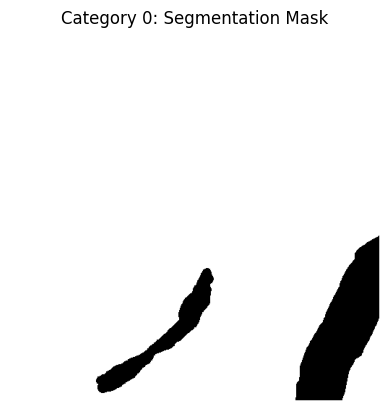

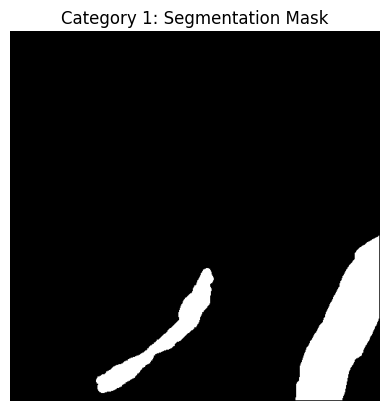

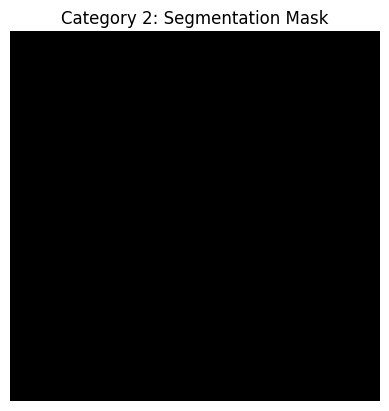

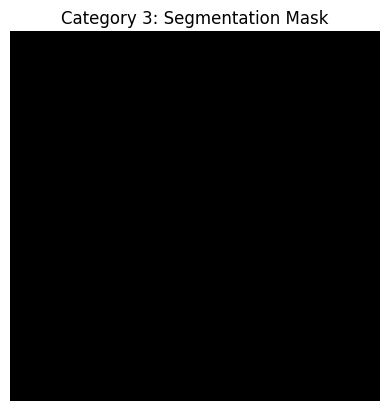

In [6]:


IMAGE_SIZE = 512  # Resize images

def load_image(image_id):
    """loads an image from COCO dataset and resize it"""
    coco_path = "/kaggle/input/hubmap-preprocessed-data/my-hubmap-hacking-the-human-vasculature-dataset-old-combined/coco_data/data"
    image_info = coco.loadImgs(image_id)[0]

    image_path = os.path.join(coco_path, image_info["file_name"])  
    # loads the image in color mode (ignoring transparency).
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 256 for experimentation
    
    return image



def create_binary_mask(image_id, height=512, width=512, selected_classes=[0,1,2]):
    """
    Create a binary mask for a given image ID and selected classes.
    """
    mask = np.zeros((height, width, len(selected_classes)), dtype=np.uint8)  # Multi-channel binary mask

    # Get all annotations for this image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        category_id = ann["category_id"]
        if category_id in selected_classes:  # Only process selected classes
            
            class_index = selected_classes.index(category_id)  # Get channel index
            segmentation = ann["segmentation"]

            # Convert segmentation to mask
            rle = maskUtils.frPyObjects(segmentation, height, width)
            binary_mask = maskUtils.decode(rle).sum(axis=2).astype(np.uint8)


            # Assign to the correct channel
            mask[:, :, class_index] = np.maximum(mask[:, :, class_index], binary_mask)



    return mask  # Shape: (height, width, 3)



def preprocess_mask(binary_mask, target_size=(512, 512)):
    """
    Resize binary masks to a fixed target size.
    """
    resized_mask = np.zeros((*target_size, binary_mask.shape[-1]), dtype=np.uint8)
    
    for i in range(binary_mask.shape[-1]):  # Resize each class separately
        resized_mask[:, :, i] = cv2.resize(binary_mask[:, :, i], target_size, interpolation=cv2.INTER_NEAREST)

    return resized_mask

def convert_to_one_hot(binary_mask):
    """
    Convert a binary mask (H, W, C) into a one-hot encoded mask (H, W, num_classes+1).
    Background is treated as class 0.
    """
    num_classes = binary_mask.shape[-1] + 1  # Include background
    one_hot_mask = np.zeros((*binary_mask.shape[:2], num_classes), dtype=np.uint8)

    for i in range(binary_mask.shape[-1]):  # Assign each class a different label
        one_hot_mask[:, :, i+1] = binary_mask[:, :, i]  # Shift by 1 to reserve background (0)
        one_hot_mask[:, :, 0] += binary_mask[:, :, i] 
    one_hot_mask[:, :, 0] = 1 - one_hot_mask[:, :, 0]
    return one_hot_mask

def load_mask(image_id,height=512, width=512, selected_classes=[0,1,2]):
    # Create binary mask
    binary_mask = create_binary_mask(image_id,height, width, selected_classes)
    binary_mask_resized = preprocess_mask(binary_mask,(height, width))
    one_hot_mask = convert_to_one_hot(binary_mask_resized)
    return one_hot_mask



image_ids = coco.getImgIds()

# load sample image and mask
sample_id = image_ids[421] #248 has all 3 classes

sample_image = load_image(sample_id)

sample_mask = load_mask(sample_id)


# display Image & Mask
plt.figure(figsize=(10, 5))

plt.imshow(sample_image)
plt.axis("off")
plt.title("Image")
plt.show()

plt.imshow(sample_mask[:,:,0], cmap="gray")
plt.axis("off")
plt.title("Category 0: Segmentation Mask")
plt.show()

plt.imshow(sample_mask[:,:,1], cmap="gray")
plt.axis("off")
plt.title("Category 1: Segmentation Mask")
plt.show()

plt.imshow(sample_mask[:,:,2], cmap="gray")
plt.axis("off")
plt.title("Category 2: Segmentation Mask")
plt.show()

plt.imshow(sample_mask[:,:,3], cmap="gray")
plt.axis("off")
plt.title("Category 3: Segmentation Mask")



plt.show()

Load Train data

In [7]:
X_train = np.array([load_image(img_id) for img_id in image_ids[:420]])  # Load first 420 images
Y_train = np.array([load_mask(img_id) for img_id in image_ids[:420]])
print("Image Data Shape:", X_train.shape)
print("Mask Data Shape:", Y_train.shape)

Image Data Shape: (420, 512, 512, 3)
Mask Data Shape: (420, 512, 512, 4)


In [8]:
# print("Any NaN in X_train?", np.isnan(X_train).any())
# print("Any NaN in Y_train?", np.isnan(Y_train).any())
# print("Unique values in Y_train:", np.unique(Y_train))

In [9]:
!pip install albumentations opencv-python

In [10]:
import numpy as np

#compute class freq and weights
def compute_class_weights(masks):
    pixels_per_class = masks.sum(axis=(0,1,2))
    total_pixels = pixels_per_class.sum()
    class_weights = total_pixels / (len(pixels_per_class) * pixels_per_class)
    return class_weights, pixels_per_class

class_weights, class_counts = compute_class_weights(Y_train)

# identify rare classes based on threshold
def get_rare_classes(class_counts, percentile=25):
    print(class_counts)
    threshold = np.percentile(class_counts, percentile)
    rare_classes = np.where(class_counts <= threshold)[0]
    return rare_classes

rare_classes = get_rare_classes(class_counts)
print(f"rare_classes: {rare_classes}")



#Filter the dataset to find which images contain rare classes:
def contains_rare_class(mask, rare_classes):
    mask_classes_present = np.unique(np.argmax(mask, axis=-1))
    return any(rc in mask_classes_present for rc in rare_classes)
images = []
masks= []
for img, mask in zip(X_train, Y_train):
    if contains_rare_class(mask, rare_classes):
        for _ in range(2):  # duplicate rare class samples
            images.append(img)
            masks.append(mask)
images = np.array(images)
masks = np.array(masks)
X_train = np.concatenate((X_train, images), axis=0)
Y_train = np.concatenate((Y_train, masks), axis=0)

rare_class_indices = [i for i, mask in enumerate(Y_train) if contains_rare_class(mask, rare_classes)]

#print(f"rare_class_indices: {rare_class_indices}")

import albumentations as A

# Aggressive augmentation for rare classes
aggressive_aug = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
    A.RandomRotate90(p=0.8),
    #A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.7),
    A.GridDistortion(p=0.7),
    A.RandomBrightnessContrast(p=0.5),
], additional_targets={'mask': 'mask'})

# Moderate augmentation for common classes
moderate_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], additional_targets={'mask': 'mask'})

def one_hot_to_int(mask):
    return np.argmax(mask, axis=-1).astype(np.uint8)

def int_to_one_hot(mask_int, num_classes):
    return np.eye(num_classes)[mask_int]

def conditional_augment(image, mask_one_hot, rare_classes):
    mask_int = one_hot_to_int(mask_one_hot)
    num_classes = mask_one_hot.shape[-1]

    # Decide augmentation pipeline
    if contains_rare_class(mask_one_hot, rare_classes):
        augmented = aggressive_aug(image=image, mask=mask_int)
    else:
        augmented = moderate_aug(image=image, mask=mask_int)

    aug_image = augmented['image']
    aug_mask_int = augmented['mask']
    aug_mask_one_hot = int_to_one_hot(aug_mask_int, num_classes)

    return aug_image, aug_mask_one_hot


[100466510   6926946   1527117   1893635]
rare_classes: [2]


/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [11]:
print("Image Data Shape:", X_train.shape)
print("Mask Data Shape:", Y_train.shape)

Image Data Shape: (488, 512, 512, 3)
Mask Data Shape: (488, 512, 512, 4)


In [12]:
X_aug= []
Y_aug = []

for img, mask in zip(X_train, Y_train):
    aug_img, aug_mask = conditional_augment(img, mask, rare_classes)
    X_aug.append(aug_img)
    Y_aug.append(aug_mask)

X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)


In [13]:
print(f"{X_aug.shape}{Y_aug.shape}")

(488, 512, 512, 3)(488, 512, 512, 4)


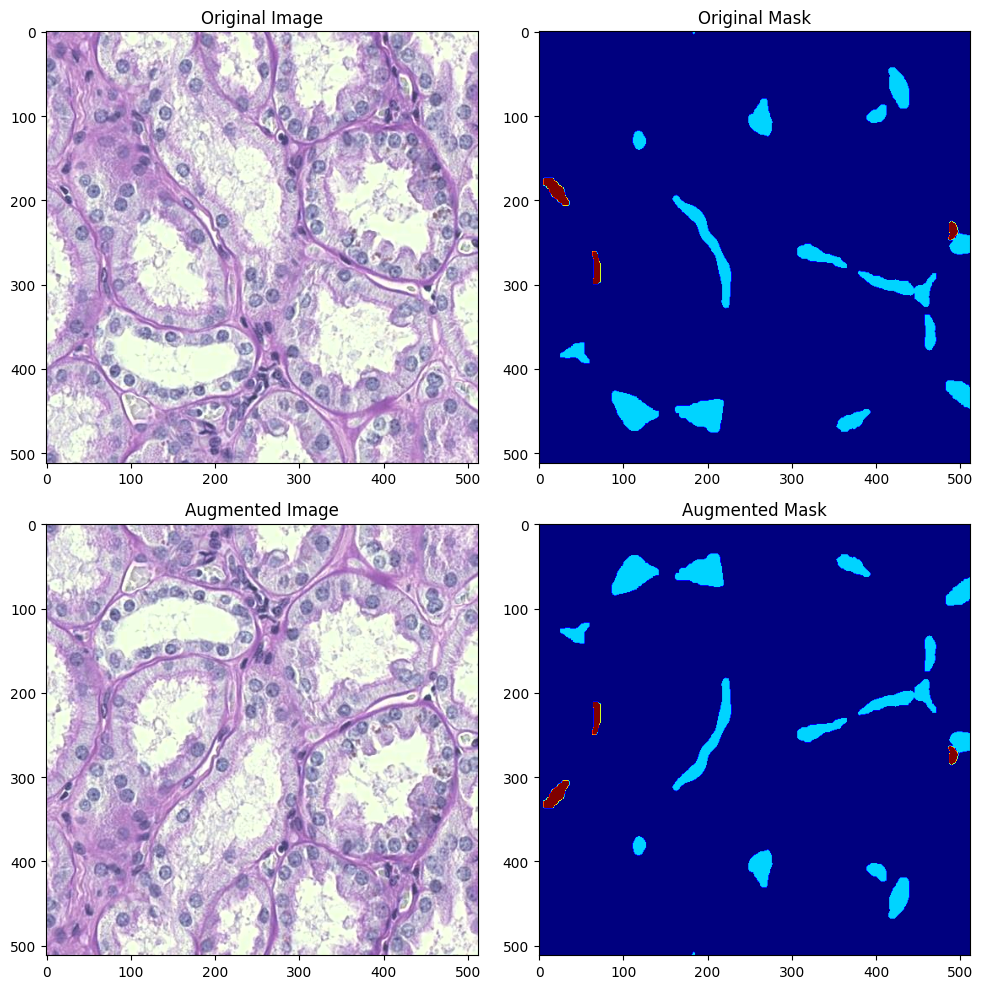

In [14]:

sample_id=320
# Visualize the results
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].imshow(cv2.cvtColor(X_train[sample_id], cv2.COLOR_BGR2RGB))
ax[0,0].set_title("Original Image")

ax[0,1].imshow(np.argmax(Y_train[sample_id], axis=-1), cmap='jet')
ax[0,1].set_title("Original Mask")

ax[1,0].imshow(cv2.cvtColor(X_aug[sample_id], cv2.COLOR_BGR2RGB))
ax[1,0].set_title("Augmented Image")

ax[1,1].imshow(np.argmax(Y_aug[sample_id], axis=-1), cmap='jet')
ax[1,1].set_title("Augmented Mask")

plt.tight_layout()
plt.show()

In [15]:
X_train = np.concatenate((X_train,X_aug), axis=0)
Y_train = np.concatenate((Y_train, Y_aug), axis=0)

In [16]:
print("Image Data Shape:", X_train.shape)
print("Mask Data Shape:", Y_train.shape)

Image Data Shape: (976, 512, 512, 3)
Mask Data Shape: (976, 512, 512, 4)


In [17]:
print("Image Data Shape:", X_train.shape)
print("Mask Data Shape:", Y_train.shape)

Image Data Shape: (976, 512, 512, 3)
Mask Data Shape: (976, 512, 512, 4)


In [18]:
# Clear previous session to free memory
import tensorflow.keras.backend as K
import gc
K.clear_session()
gc.collect()

0

In [19]:
import numpy as np

def compute_class_weights(one_hot_masks):
    """
    Compute class weights based on pixel frequency in one-hot encoded masks.
    
    Args:
        one_hot_masks: NumPy array of shape (num_samples, H, W, num_classes)
    
    Returns:
        List of class weights (inverse frequency)
    """
    num_classes = one_hot_masks.shape[-1]  # Get number of classes
    
    # Flatten to count pixels across the entire dataset
    pixel_counts = np.sum(one_hot_masks, axis=(0, 1, 2))  # Sum over all samples, H, W
    
    # Compute weights using inverse frequency (less frequent classes get higher weight)
    class_weights = np.max(pixel_counts) / (pixel_counts + 1e-6)  # Add epsilon to avoid division by zero
    
    # Normalize to keep sum of weights reasonable
    class_weights /= np.sum(class_weights)

    return class_weights.tolist()  # Convert to list for TensorFlow compatibility

# Example: Compute class weights for dataset
class_weights = compute_class_weights(Y_train)  # One-hot encoded Y_train
print("Class Weights:", class_weights)


Class Weights: [0.010683963341868576, 0.15137739796373112, 0.26428899860515026, 0.5736496400892501]


Create model

In [20]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout

# def unet_model(input_size=(512, 512, 3), num_classes=4):  # 3 classes + background
#     inputs = Input(input_size)

#     # Encoder (Downsampling Path)
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    # conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    # conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    # pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    # conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    # conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    # drop4 = Dropout(0.5)(conv4)
    # pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # # Bottleneck
    # conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    # conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    # drop5 = Dropout(0.5)(conv5)

    # # Decoder (Upsampling Path)
    # up6 = UpSampling2D(size=(2, 2))(drop5)
    # merge6 = Concatenate()([drop4, up6])
    # conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    # conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    # up7 = UpSampling2D(size=(2, 2))(conv6)
    # merge7 = Concatenate()([conv3, up7])
    # conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    # conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    # up8 = UpSampling2D(size=(2, 2))(conv7)
    # merge8 = Concatenate()([conv2, up8])
    # conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = UpSampling2D(size=(2, 2))(conv8)
#     merge9 = Concatenate()([conv1, up9])
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

#     # Output Layer: Softmax for Multi-Class Segmentation
#     output = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

#     model = Model(inputs=inputs, outputs=output)
#     return model

# # Initialize U-Net for 3-Class Segmentation
# model = unet_model(num_classes=4)
# model.summary()


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def unet_5x5(input_shape=(512, 512, 3), num_classes=4):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (5, 5), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (5, 5), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (5, 5), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (5, 5), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (5, 5), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (5, 5), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (5, 5), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bridge
    c5 = Conv2D(512, (5, 5), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (5, 5), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (5, 5), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (5, 5), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (5, 5), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (5, 5), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (5, 5), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (5, 5), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (5, 5), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (5, 5), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the model
model = unet_5x5()

# # Compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │          2,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │         25,632 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         51,264 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │        102,464 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │        204,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        409,728 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        819,456 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │      1,638,656 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 512)    │      3,277,312 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 512)    │      6,554,112 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │      3,277,056 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 23,967,556 (91.43 MB)

 Trainable params: 23,967,556 (91.43 MB)

 Non-trainable params: 0 (0.00 B)

Integrate mAP as metric

In [22]:
class CheckNaNLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and (np.isnan(logs["loss"]) or np.isnan(logs["val_loss"])):
            print(f"\n🚨 NaN detected in loss at epoch {epoch+1}! Stopping training.")
            self.model.stop_training = True  # Stop training if NaN appears

nan_checker = CheckNaNLoss()

In [23]:
from tensorflow.keras.optimizers import Adam

In [24]:
num_classes=4

In [25]:

# import numpy as np

# def compute_class_weights(masks):
#     # masks shape: (N, H, W, num_classes)
#     pixels_per_class = masks.sum(axis=(0, 1, 2))
#     total_pixels = pixels_per_class.sum()
#     class_weights = total_pixels / (len(pixels_per_class) * pixels_per_class)
#     return class_weights

# # Example usage:
# class_weights = compute_class_weights(Y_train)

# import tensorflow as tf

# def weighted_categorical_crossentropy(weights):
#     weights = tf.constant(weights, dtype=tf.float32)
    
#     def loss_fn(y_true, y_pred):
#         # Ensure numerical stability
#         y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
#         # Compute standard categorical cross-entropy
#         cce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        
#         # Apply class weights
#         weight_map = tf.reduce_sum(weights * y_true, axis=-1)
#         weighted_cce = weight_map * cce
        
#         return tf.reduce_mean(weighted_cce)
    
#     return loss_fn
    
# import tensorflow as tf

# def dice_loss(y_true, y_pred, smooth=1e-6):
#     intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
#     denominator = tf.reduce_sum(y_true + y_pred, axis=[1,2])
#     dice = (2. * intersection + smooth) / (denominator + smooth)
#     return 1 - tf.reduce_mean(dice)

# def multiclass_dice_loss(y_true, y_pred, smooth=1e-6):
#     dice_per_class = []
#     num_classes = y_true.shape[-1]  # <-- Fix here: use static shape

#     for i in range(num_classes):
#         dice = dice_loss(y_true[..., i], y_pred[..., i], smooth)
#         dice_per_class.append(dice)

#     return tf.reduce_mean(dice_per_class)

    
#     return tf.reduce_mean(dice_per_class)
# def combined_dice_weighted_ce_loss(class_weights, dice_weight=0.2, ce_weight=0.8):
#     weighted_ce = weighted_categorical_crossentropy(class_weights)
    
#     def loss(y_true, y_pred):
#         dice = multiclass_dice_loss(y_true, y_pred)
#         w_ce = weighted_ce(y_true, y_pred)
        
#         return dice_weight * dice + ce_weight * w_ce
    
#     return loss



In [26]:

import numpy as np

def compute_class_weights(masks):
    # masks shape: (N, H, W, num_classes)
    pixels_per_class = masks.sum(axis=(0, 1, 2))
    total_pixels = pixels_per_class.sum()
    class_weights = total_pixels / (len(pixels_per_class) * pixels_per_class)
    return class_weights

# Example usage:
class_weights = compute_class_weights(Y_train)

import tensorflow as tf

def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss_fn(y_true, y_pred):
        # Ensure numerical stability
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Compute standard categorical cross-entropy
        cce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        
        # Apply class weights
        weight_map = tf.reduce_sum(weights * y_true, axis=-1)
        weighted_cce = weight_map * cce
        
        return tf.reduce_mean(weighted_cce)
    
    return loss_fn
    
import tensorflow as tf


def weighted_dice_score(y_true, y_pred, class_weights=None, smooth=1e-6):
    """
    Compute the weighted Dice score for multi-class segmentation.
    
    Args:
        y_true: one-hot encoded ground truth, shape = [batch, H, W, C]
        y_pred: softmax output from model, shape = [batch, H, W, C]
        class_weights: list or array of shape [C] with weights per class
        smooth: smoothing constant to avoid division by zero

    Returns:
        Scalar Dice score (weighted average over classes)
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Per-class Dice score
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    y_true_sum = tf.reduce_sum(y_true, axis=[0, 1, 2])
    y_pred_sum = tf.reduce_sum(y_pred, axis=[0, 1, 2])
    dice = (2. * intersection + smooth) / (y_true_sum + y_pred_sum + smooth)

    if class_weights is not None:
        class_weights = tf.constant(class_weights, dtype=tf.float32)
        dice = dice * class_weights
        dice = tf.reduce_sum(dice) / tf.reduce_sum(class_weights)
    else:
        dice = tf.reduce_mean(dice)

    return dice


    
    return tf.reduce_mean(dice_per_class)
def combined_dice_weighted_ce_loss(class_weights, dice_weight=0.8, ce_weight=0.2):
    weighted_ce = weighted_categorical_crossentropy(class_weights)
    
    def loss(y_true, y_pred):
        dice = weighted_dice_score(y_true, y_pred, class_weights=class_weights)
        w_ce = weighted_ce(y_true, y_pred)
        
        return dice_weight * dice + ce_weight * w_ce
    
    return loss



In [27]:
print(f"{class_weights}")

[ 0.28240704  4.00132817  6.98589769 15.16316501]


In [28]:
!rm -rf /kaggle/working/*

Call back to save weights every epoch

In [29]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model_iou.weights.h5",
    monitor="val_loss",  # Track IoU instead of loss
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save weights only (faster)
    verbose=1 #,
    #mode='max'
)

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [31]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import math

import tensorflow as tf
import math

import tensorflow as tf
import math

class CosineWarmupScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, total_steps, warmup_steps, max_lr, min_lr=1e-6):
        super().__init__()
        self.total_steps = tf.cast(total_steps, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.max_lr = tf.cast(max_lr, tf.float32)
        self.min_lr = tf.cast(min_lr, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Linear warmup
        def warmup():
            return self.max_lr * (step / self.warmup_steps)

        # Cosine annealing after warmup
        def cosine_decay():
            progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            cosine_decay = 0.5 * (1 + tf.cos(math.pi * progress))
            return self.min_lr + (self.max_lr - self.min_lr) * cosine_decay

        return tf.cond(step < self.warmup_steps, warmup, cosine_decay)

    def get_config(self):
        return {
            "total_steps": self.total_steps.numpy(),
            "warmup_steps": self.warmup_steps.numpy(),
            "max_lr": self.max_lr.numpy(),
            "min_lr": self.min_lr.numpy(),
        }





# Define total_steps based on your dataset:
epochs = 35
batch_size = 4
steps_per_epoch = len(X_train) // batch_size
total_steps = epochs * steps_per_epoch
warmup_steps = int(0.1 * total_steps)

# Instantiate your scheduler
lr_schedule = CosineWarmupScheduler(total_steps, warmup_steps, max_lr=0.0001)

# Pass the callable directly to the optimizer
optimizer = SGD(learning_rate=lr_schedule, momentum=0.009)





In [32]:
#class_weights = [ 0.2823753,  5.000934 ,   6.99138765, 15.23483088] #[0.3,15,8,5]

In [33]:
model.compile(
    optimizer=optimizer,
    loss=combined_dice_weighted_ce_loss(class_weights),  # replace with your loss
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)


In [34]:
class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = lr(self.model.optimizer.iterations)
        else:
            current_lr = tf.keras.backend.get_value(lr)
        
        print(f"Epoch {epoch+1}: Learning Rate = {current_lr:.6f}")

In [35]:
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [36]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[nan_checker,checkpoint_callback, early_stopping_callback, LRTensorBoard()])

Epoch 1/35
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8070 - loss: 1.9827 - mean_io_u: 0.4666
Epoch 1: val_loss improved from inf to 1.34952, saving model to /kaggle/working/best_model_iou.weights.h5
Epoch 1: Learning Rate = 0.000023
195/195 ━━━━━━━━━━━━━━━━━━━━ 153s 617ms/step - accuracy: 0.8066 - loss: 1.9821 - mean_io_u: 0.4665 - val_accuracy: 0.3898 - val_loss: 1.3495 - val_mean_io_u: 0.2489
Epoch 2/35
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7533 - loss: 1.6248 - mean_io_u: 0.4092
Epoch 2: val_loss improved from 1.34952 to 1.00903, saving model to /kaggle/working/best_model_iou.weights.h5
Epoch 2: Learning Rate = 0.000046
195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 545ms/step - accuracy: 0.7530 - loss: 1.6227 - mean_io_u: 0.4092 - val_accuracy: 0.8158 - val_loss: 1.0090 - val_mean_io_u: 0.2499
Epoch 3/35
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6657 - loss: 0.9668 - mean_io_u: 0.2557
Epoch 3: val_loss improved from 1.00903 to 0.62637, saving mod

In [37]:
# model.load_weights("/kaggle/working/best_model_iou.weights.h5")
# print("✅ Weights loaded successfully!")




In [38]:
# model.compile(
#     optimizer=optimizer,
#     loss=combined_dice_weighted_ce_loss(class_weights),  # replace with your loss
#     metrics=['accuracy']
# )

In [39]:
#history = model.fit(X_train, Y_train, epochs=5, batch_size=4, validation_split=0.2, callbacks=[nan_checker,checkpoint_callback])

In [40]:
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
# import json

# # Load ground truth annotations
# coco_gt = COCO("path/to/ground_truth.json")

# # Load predicted annotations
# coco_dt = coco_gt.loadRes("path/to/predictions.json")

# # Create COCO evaluator
# coco_eval = COCOeval(coco_gt, coco_dt, "segm")  # Use "bbox" for object detection

# # Run evaluation
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Class 0 - IoU: 0.4763, Dice: 0.6452
Class 1 - IoU: 0.0563, Dice: 0.1066
Class 2 - IoU: 0.0000, Dice: 0.0000
Class 3 - IoU: 0.0249, Dice: 0.0486
[0 1 2 3]


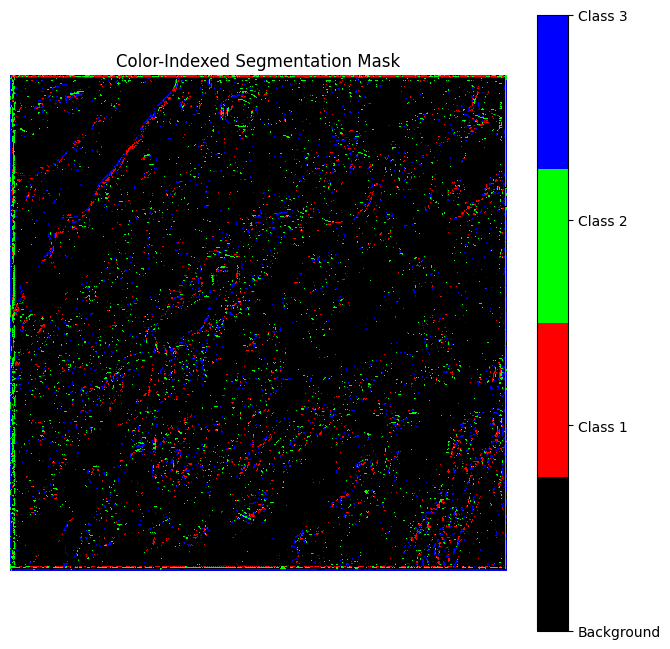

One-Hot Encoded Mask Shape: (1, 512, 512, 4)


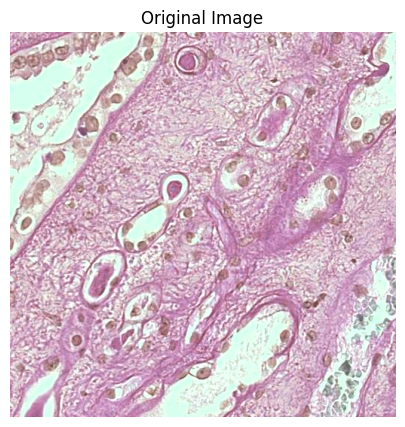

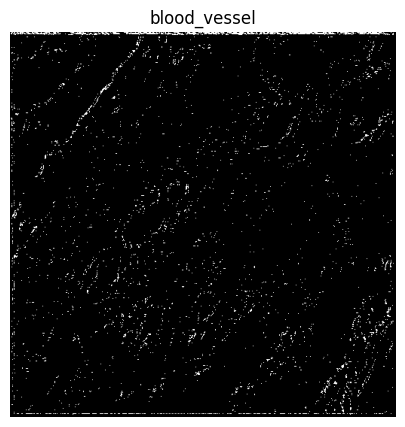

[0 1]


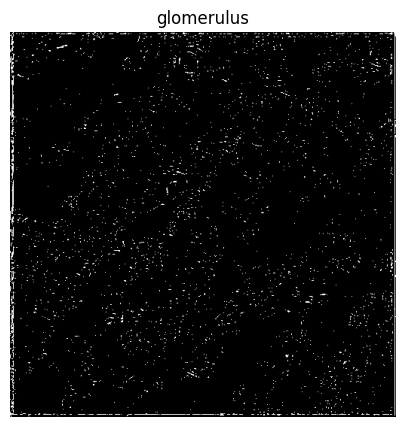

[0 1]


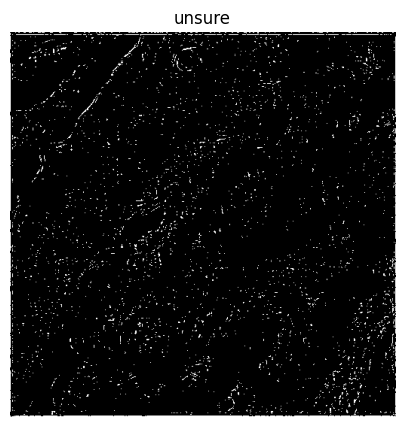

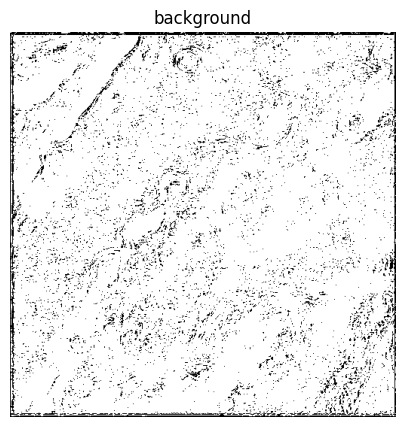

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.colors import ListedColormap

num_classes = 4  # Total number of classes
test_id=421
# Select a test image
test_img = load_image(image_ids[test_id])
test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

ground_truth_mask = load_mask(test_id)

# Predict the mask
predicted_mask = model.predict(test_img)

def calculate_iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou, axis=0)  # returns per-class IoU

def calculate_dice(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    total = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    dice = (2. * intersection + smooth) / (total + smooth)
    return tf.reduce_mean(dice, axis=0)  # returns per-class Dice
    
# Calculate IoU and Dice
iou_scores = calculate_iou(ground_truth_mask, predicted_mask)
dice_scores = calculate_dice(ground_truth_mask, predicted_mask)

# Print results per class
for i in range(num_classes):
    print(f"Class {i} - IoU: {iou_scores[i]:.4f}, Dice: {dice_scores[i]:.4f}")


class_index_mask = tf.argmax(predicted_mask, axis=-1) 
print(np.unique(class_index_mask))



# Define custom colors for each class (background + 3 classes)
colors = [
    '#000000',  # Class 0: Background (Black)
    '#FF0000',  # Class 1: Red
    '#00FF00',  # Class 2: Green
    '#0000FF',  # Class 3: Blue
]

# Create the colormap
cmap = ListedColormap(colors)

plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(class_index_mask).numpy(), cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(ticks=range(len(colors)))
cbar.ax.set_yticklabels(['Background', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Color-Indexed Segmentation Mask')
plt.axis('off')
plt.show()




# Convert to one-hot encoding (shape: H x W x num_classes)
binary_mask = tf.one_hot(class_index_mask, depth=num_classes, axis=-1, dtype=tf.uint8)

print("One-Hot Encoded Mask Shape:", binary_mask.shape)  # Expected: (H, W, num_classes)

# Display the image and predicted mask
plt.figure(figsize=(10, 5))

plt.imshow(load_image(image_ids[test_id]))  # Original image
plt.axis("off")
plt.title("Original Image")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
# print(f"{np.unique(binary_mask[0,:,:,1])}")
# indices = np.argwhere(binary_mask[0,:,:,1] == 1)

# print("Indices where binary mask is 1:\n", indices)
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,1], cmap="gray") 
plt.axis("off")
plt.title("blood_vessel")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
print(f"{np.unique(binary_mask[0,:,:,2])}")
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,2], cmap="gray") 
plt.axis("off")
plt.title("glomerulus")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
print(f"{np.unique(binary_mask[0,:,:,3])}")
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,3], cmap="gray") 
plt.axis("off")
plt.title("unsure")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,0], cmap="gray") 
plt.axis("off")
plt.title("background")

plt.show()


✅ Weights loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Class 0 - IoU: 0.4763, Dice: 0.6452
Class 1 - IoU: 0.0563, Dice: 0.1066
Class 2 - IoU: 0.0000, Dice: 0.0000
Class 3 - IoU: 0.0249, Dice: 0.0486
[0 1 2 3]


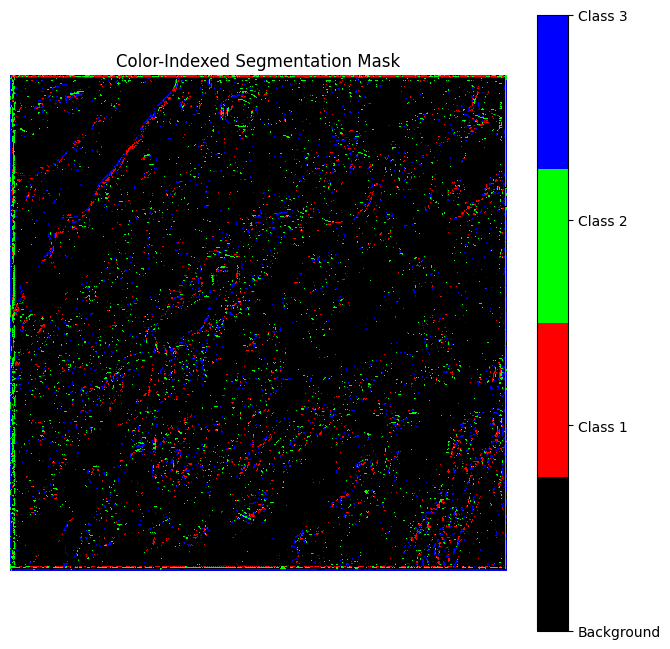

One-Hot Encoded Mask Shape: (1, 512, 512, 4)


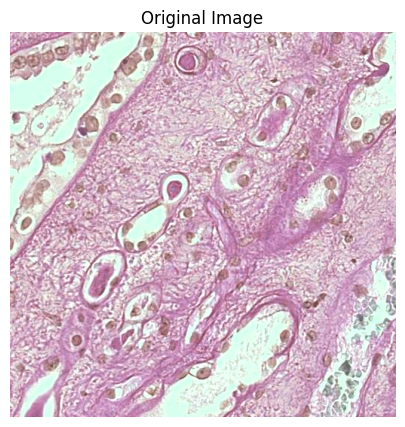

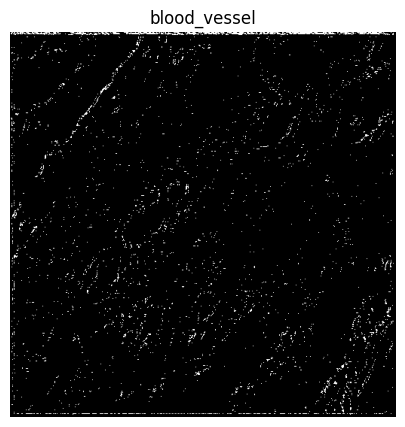

[0 1]


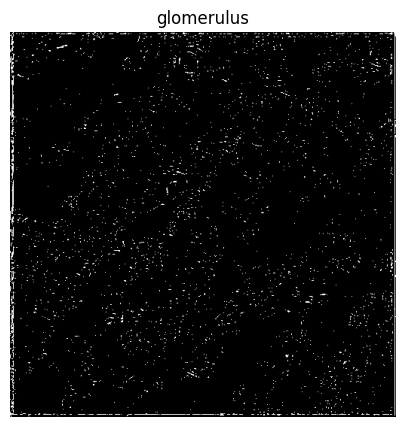

[0 1]


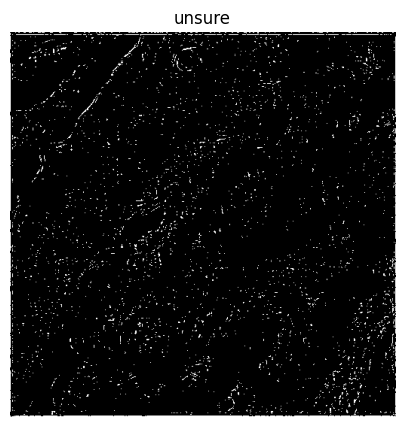

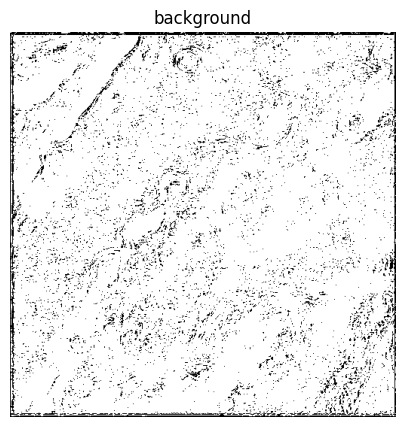

In [42]:
model.load_weights("/kaggle/working/best_model_iou.weights.h5")
print("✅ Weights loaded successfully!")

model.compile(
    optimizer=optimizer,
    loss=combined_dice_weighted_ce_loss(class_weights),  # replace with your loss
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.colors import ListedColormap

num_classes = 4  # Total number of classes
test_id=421
# Select a test image
test_img = load_image(image_ids[test_id])
test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

ground_truth_mask = load_mask(test_id)

# Predict the mask
predicted_mask = model.predict(test_img)

def calculate_iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou, axis=0)  # returns per-class IoU

def calculate_dice(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    total = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    dice = (2. * intersection + smooth) / (total + smooth)
    return tf.reduce_mean(dice, axis=0)  # returns per-class Dice
    
# Calculate IoU and Dice
iou_scores = calculate_iou(ground_truth_mask, predicted_mask)
dice_scores = calculate_dice(ground_truth_mask, predicted_mask)

# Print results per class
for i in range(num_classes):
    print(f"Class {i} - IoU: {iou_scores[i]:.4f}, Dice: {dice_scores[i]:.4f}")


class_index_mask = tf.argmax(predicted_mask, axis=-1) 
print(np.unique(class_index_mask))



# Define custom colors for each class (background + 3 classes)
colors = [
    '#000000',  # Class 0: Background (Black)
    '#FF0000',  # Class 1: Red
    '#00FF00',  # Class 2: Green
    '#0000FF',  # Class 3: Blue
]

# Create the colormap
cmap = ListedColormap(colors)

plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(class_index_mask).numpy(), cmap=cmap, interpolation='nearest')
cbar = plt.colorbar(ticks=range(len(colors)))
cbar.ax.set_yticklabels(['Background', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Color-Indexed Segmentation Mask')
plt.axis('off')
plt.show()




# Convert to one-hot encoding (shape: H x W x num_classes)
binary_mask = tf.one_hot(class_index_mask, depth=num_classes, axis=-1, dtype=tf.uint8)

print("One-Hot Encoded Mask Shape:", binary_mask.shape)  # Expected: (H, W, num_classes)

# Display the image and predicted mask
plt.figure(figsize=(10, 5))

plt.imshow(load_image(image_ids[test_id]))  # Original image
plt.axis("off")
plt.title("Original Image")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
# print(f"{np.unique(binary_mask[0,:,:,1])}")
# indices = np.argwhere(binary_mask[0,:,:,1] == 1)

# print("Indices where binary mask is 1:\n", indices)
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,1], cmap="gray") 
plt.axis("off")
plt.title("blood_vessel")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
print(f"{np.unique(binary_mask[0,:,:,2])}")
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,2], cmap="gray") 
plt.axis("off")
plt.title("glomerulus")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
print(f"{np.unique(binary_mask[0,:,:,3])}")
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,3], cmap="gray") 
plt.axis("off")
plt.title("unsure")
plt.show()

# plt.imshow(predicted_mask_thresh, cmap="gray")  # Predicted mask
plt.figure(figsize=(10, 5))
plt.imshow(binary_mask[0,:,:,0], cmap="gray") 
plt.axis("off")
plt.title("background")

plt.show()
